# **Cointegration Testing Analysis and Stock Chain Visual for the AAPL Stock**
## In this notebook we start to bring things together from other sections of the project.  We combine our analyzed and preprocessed core_stock_data with our preprocessed and dynamically generated secondary stock data to perform cointegration testing to see if we can create cointegrated pairs, which we will then visualize to produce our intended stock chain.  We will also utlize and test our exogenous data and features here; data we haven't talked about a whole lot yet.  This data will aid in potentially adding another layer to the stock chains we want to create, reducing risk when we go to develop our trading strategy in a few phases of our project.

#### As with our other notebooks let's read in our data to use for this.  This time let's take a good look at the shape of our dataframes since we will plan on merging them later on in the notebook.  It will be important that the dataframes match in size so that modeling works for our Decision Trees.  If they mismatch we will have to investigate.

In [1]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import coint, adfuller
import networkx as nx

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# Now let's access the main core_stock_data.csv file, as well as the secondary stock data and exo_data to all be used in this notebook!
csv_path = os.path.join(project_root, 'data', 'core_stock_unscaled.csv')
core_stock_data = pd.read_csv(csv_path, parse_dates=['Date'], index_col= 'Date')
print(core_stock_data.head())
print(core_stock_data.shape)

csv_path = os.path.join(project_root, 'data', 'sec_stock_unscaled.csv')
sec_stock_data = pd.read_csv(csv_path, parse_dates=['Date'], index_col= 'Date')
print(sec_stock_data.head())
print(sec_stock_data.shape)

csv_path = os.path.join(project_root, 'data', 'exo_data_unscaled.csv')
exo_data = pd.read_csv(csv_path, parse_dates=['Date'], index_col= 'Date')

print(exo_data.head())
print(exo_data.shape)




            Close_core  Volume_core  Open_core  High_core   Low_core  \
Date                                                                   
2019-03-14   45.932499   94318000.0  45.974998  46.025002  45.639999   
2019-03-15   46.529999  156171600.0  46.212502  46.832500  45.935001   
2019-03-18   47.005001  104879200.0  46.450001  47.097500  46.447498   
2019-03-19   46.632500  126585600.0  47.087502  47.247501  46.480000   
2019-03-20   47.040001  124140800.0  46.557499  47.372501  46.182499   

            SMA_core   EMA_core   RSI_core  BBM_core   BBU_core  ...  \
Date                                                             ...   
2019-03-14  41.35925  42.219051  75.741602  41.35925  46.695085  ...   
2019-03-15  41.50025  42.388107  76.985910  41.50025  47.003365  ...   
2019-03-18  41.72940  42.569162  78.724282  41.72940  47.174667  ...   
2019-03-19  41.92075  42.728509  73.527018  41.92075  47.369412  ...   
2019-03-20  42.12190  42.897587  80.396901  42.12190  47.569044

In [3]:
exo_only_dates = exo_data.index.difference(core_stock_data.index)
print(exo_only_dates)



DatetimeIndex(['2019-04-19', '2019-05-27', '2019-07-04', '2019-09-02',
               '2019-11-28', '2019-12-25', '2020-01-01', '2020-01-20',
               '2020-02-17', '2020-04-10', '2020-05-25', '2020-07-03',
               '2020-09-07', '2020-11-26', '2020-12-25', '2021-01-01',
               '2021-01-18', '2021-02-15', '2021-04-02', '2021-05-31',
               '2021-07-05', '2021-09-06', '2021-11-25', '2021-12-24',
               '2022-01-17', '2022-02-21', '2022-04-15', '2022-05-30',
               '2022-06-20', '2022-07-04', '2022-09-05', '2022-11-24',
               '2022-12-26', '2023-01-02', '2023-01-16', '2023-02-20',
               '2023-04-07', '2023-05-29', '2023-06-19', '2023-07-04',
               '2023-09-04', '2023-11-23', '2023-12-25', '2024-01-01',
               '2024-01-15', '2024-02-19', '2024-03-29', '2024-05-27',
               '2024-06-19', '2024-07-04'],
              dtype='datetime64[ns]', name='Date', freq=None)


#### Now let's grab just our core stock for this notebook.

In [4]:
# We will want to preserve this version of our data since we will be doing merges later on, once we merge it will exponentially increase how much data is contained in our subject ticker variable.
core_stock_data = core_stock_data[core_stock_data['Ticker'] == 'AAPL'].copy()
optimized_features = ['ATR_14_core_Lag_3', 'Momentum_1_Lag_Std_1_3_core', 'Open_Lag_Std_1_3_core', 'Momentum_30_Lag_Std_1_3_core', 'Momentum_50_Lag_Std_1_3_core',
                'Low_Lag_Std_1_3_core', 'High_Lag_Std_1_3_core', 'EMA_Lag_Std_1_3_core', 'MACD_Hist_Lag_Std_1_3_core', 'OBV_core', 'MACD_Lag_Std_1_3_core',
                'ATR_14_Lag_Std_1_3_core', 'MACD_Signal_Lag_Std_1_3_core', 'OBV_core_Lag_3', 'Momentum_50_core_Lag_1', 'Momentum_50_core_Lag_3', 'Diff_Close_EMA_core',
                'BBU_Lag_Std_1_3_core', 'BBL_Lag_Std_1_3_core', 'Volume_Lag_Std_1_3_core', 'Momentum_7_core_Lag_3', 'Momentum_3_Lag_Avg_1_3_core', 'MACD_Hist_core_Lag_3',
                'Momentum_1_core_Lag_2', 'Momentum_1_core_Lag_3', 'Close_core', 'Ticker'
                ]

available_features = [feature for feature in optimized_features if feature in core_stock_data.columns]

core_stock_data = core_stock_data[available_features]

print(core_stock_data['Ticker'].head())

Date
2019-03-14    AAPL
2019-03-15    AAPL
2019-03-18    AAPL
2019-03-19    AAPL
2019-03-20    AAPL
Name: Ticker, dtype: object


#### Now looking back at exo_data I see a mismatch in our data.  Sec_stock_data is a different story as we still need it as it is for now, and we will look at it later.  For now though let's look into exo_data and fix.

In [5]:
exo_only_dates = exo_data.index.difference(core_stock_data.index)
print(exo_only_dates)

DatetimeIndex(['2019-04-19', '2019-05-27', '2019-07-04', '2019-09-02',
               '2019-11-28', '2019-12-25', '2020-01-01', '2020-01-20',
               '2020-02-17', '2020-04-10', '2020-05-25', '2020-07-03',
               '2020-09-07', '2020-11-26', '2020-12-25', '2021-01-01',
               '2021-01-18', '2021-02-15', '2021-04-02', '2021-05-31',
               '2021-07-05', '2021-09-06', '2021-11-25', '2021-12-24',
               '2022-01-17', '2022-02-21', '2022-04-15', '2022-05-30',
               '2022-06-20', '2022-07-04', '2022-09-05', '2022-11-24',
               '2022-12-26', '2023-01-02', '2023-01-16', '2023-02-20',
               '2023-04-07', '2023-05-29', '2023-06-19', '2023-07-04',
               '2023-09-04', '2023-11-23', '2023-12-25', '2024-01-01',
               '2024-01-15', '2024-02-19', '2024-03-29', '2024-05-27',
               '2024-06-19', '2024-07-04'],
              dtype='datetime64[ns]', name='Date', freq=None)


#### There are 50 different dates and values that our exo_data has that our core target data does not.  Upon first glance they appear to be related to holidays.  Let's remove these values from exo_data so that the indices align.

In [6]:
exo_data_cleaned = exo_data.drop(index = exo_only_dates)

# Now re-check shape
print(f"Exo_data shape after dropping extra values: {exo_data_cleaned.shape}")


Exo_data shape after dropping extra values: (1365, 180)


#### Now we are ready.  We have our core stock and our secondary stock data.  Before we do the cointegration tests we will perform a ADF (Augmented Dickey-Fuller) test to check for stationarity.  This will help our cointegration results.

In [7]:

# Perform ADF Test on the 'Close' price column
adf_result = adfuller(core_stock_data['Close_core'])

# Display ADF test results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])




ADF Statistic: -0.9854132994930892
p-value: 0.7585472175807795
Critical Values: {'1%': -3.435153261837347, '5%': -2.8636612797849814, '10%': -2.567899369049974}


#### Let's break down our results.  The ADF Statistic as a negative number is expected and a higher negative number here suggests stronger evidence against our hypothesis that the data is non-stationary.  The output here is fairly large which means the data is very likely to be stationary.  For the p value a value of 0 can occur when the ADF statistic is very large.  This value also aids in showing that the data is stationary.  Finally for the critical values as all being negative as well, this again shows that we can reject the null hypothesis and safely say that our core data is stationary and move on with the next phase of the notebook.

#### Now since there are 200 stocks in our secondary stock data we will need to make a function to process the tests more efficiently.

In [8]:
# Let's make a function that runs the test for our core stock for each secondary stock we have generated.
def cointegration_test_sec(core_stock_data, sec_stock_data, core_ticker):
    results = []
    
    core_data = core_stock_data[core_stock_data['Ticker'] == core_ticker]['Close_core']
    
    secondary_tickers = sec_stock_data['ticker'].unique()
    
    for ticker in secondary_tickers:
        sec_data = sec_stock_data[sec_stock_data['ticker'] == ticker]['Close_sec']
        
        # As a check ensure the lengths match by trimming the larger series (if needed)
        min_len = min(len(core_data), len(sec_data))
        core_trimmed = core_data.iloc[-min_len:]
        sec_trimmed = sec_data.iloc[-min_len:]
        
        # Perform the cointegration test.
        coint_t, p_value, critical_values = coint(core_trimmed, sec_trimmed)
        
        # Append results to our results list
        results.append({
            'Secondary_Ticker' : ticker,
            'T-Statistic' : coint_t,
            'P_value' : p_value,
            'Critical_Values' : critical_values,
            'Cointegrated' : p_value < 0.05 # True if cointegrated
        })

    # Convert the results into a dataframe
    results_df = pd.DataFrame(results)
    
    return results_df

# Call the function now and perform cointegration testing on subject core stock and all secondary stocks
results_df = cointegration_test_sec(core_stock_data, sec_stock_data, core_ticker='AAPL')

print(results_df)

# Filter and display only the cointegrated pairs
cointegrated_pairs = results_df[results_df['Cointegrated'] == True]
print("\nCointegrated Pairs:")
print(cointegrated_pairs)


    Secondary_Ticker  T-Statistic   P_value  \
0                RMD    -0.814387  0.932787   
1               AMAT    -2.290508  0.378299   
2               JNPR    -2.632174  0.224915   
3               DECK    -2.150604  0.449963   
4                JBL    -1.825677  0.617168   
..               ...          ...       ...   
195               ON    -1.828137  0.615957   
196             SWKS    -0.497450  0.964513   
197              MCD    -2.279811  0.383669   
198             ADSK    -0.781050  0.937149   
199                A    -1.380142  0.804239   

                                       Critical_Values  Cointegrated  
0    [-3.9044872726627737, -3.340613212756168, -3.0...         False  
1    [-3.9044872726627737, -3.340613212756168, -3.0...         False  
2    [-3.9044872726627737, -3.340613212756168, -3.0...         False  
3    [-3.9044872726627737, -3.340613212756168, -3.0...         False  
4    [-3.9044872726627737, -3.340613212756168, -3.0...         False  
..       

#### Neat!  Out of our 200 secondary stocks that we generated and preprocessed, we have 3 cointegration pairs with our core stock!  For this notebook using AAPL as our core stock it looks like AZN, ROL, and VTRS (AstraZeneca PLC, Rollins Inc, and Viatris Inc respectively) are the cointegrated pairs as their p-value is less than 0.05 which is the deterministic stat for the cointegration test.

#### We will now do the same cointegration test on our exogenous features.

In [9]:
# Let's make a function that runs the test for our core stock for each exogenous feature we have generated.
def cointegration_test_exo(core_stock_data, exo_data_cleaned, core_ticker):
    results = []
    
    core_data = core_stock_data[core_stock_data['Ticker'] == core_ticker]['Close_core']
    
    exo_features = ['nasdaq_100', 'sp500', 'interest_rates_10yr', 'gold', 'copper', 'platinum', 'silver', 'crude_oil', 'natural_gas', 'corn', 'wheat', 'volatility_index', 'exchange_rate_usd_eur', 'exchange_rate_usd_jpy', 'dow_jones_industrial_average', 'consumer_confidence_index', 'vanguard_total_world_stock_etf', 'us_treasury_bond_etf']
    
    for feature in exo_features:
        exo_series = exo_data_cleaned[feature]
        
        # Perform the cointegration test.
        coint_t, p_value, critical_values = coint(core_data, exo_series)
        
        # Append results to our results list
        results.append({
            'Exogenous_Feature' : feature,
            'T-Statistic' : coint_t,
            'P_value' : p_value,
            'Critical_Values' : critical_values,
            'Cointegrated' : p_value < 0.05 # True if cointegrated
        })

    # Convert the results into a dataframe
    results_df = pd.DataFrame(results)
    
    return results_df

# Call the function now and perform cointegration testing on subject core stock and all secondary stocks
results_df_exo = cointegration_test_exo(core_stock_data, exo_data_cleaned, core_ticker='AAPL')

print(results_df_exo)

# Filter and display only the cointegrated pairs
cointegrated_exo = results_df_exo[results_df_exo['Cointegrated'] == True]

# In case no cointegration is found, we need some error logic.
if cointegrated_exo.empty:
    print("No exogenous features are cointegrated with our core ticker.")
else:
    print("\nCointegrated Exogenous Pairs:")
    print(cointegrated_exo)




                 Exogenous_Feature  T-Statistic   P_value  \
0                       nasdaq_100    -1.595764  0.722675   
1                            sp500    -2.174622  0.437486   
2              interest_rates_10yr    -2.100665  0.476020   
3                             gold    -2.543518  0.260221   
4                           copper    -1.800987  0.629243   
5                         platinum    -1.119751  0.877682   
6                           silver    -2.273159  0.387020   
7                        crude_oil    -1.722480  0.666556   
8                      natural_gas    -0.837346  0.929616   
9                             corn    -0.550604  0.960528   
10                           wheat    -0.961956  0.909828   
11                volatility_index    -1.264144  0.840295   
12           exchange_rate_usd_eur    -1.147543  0.871107   
13           exchange_rate_usd_jpy    -2.073559  0.490193   
14    dow_jones_industrial_average    -2.709884  0.196044   
15       consumer_confid

#### Unfortunately none of our exogenous features are cointegrated with our core ticker in this notebook at this time.  At another time we can look at expanding on our list of features in this space or the time period used but right now we will just move forward.

#### Now that we have done the initial cointegration testing we will now expand and look at layering.  We will take our cointegrated pairs that we had (3 of them) and do cointegration tests with them, so tests are done independently of themselves against the secondary stock data and exogenous data.  If pairs are found then they become layer 2 and branches of that pair, and testing will continue with that next layer until there is nothing left to test.

#### One thing we will be introducing is a threshold for our p_value.  As new cointegration pairs are introduced and new layers are created this can get out of hand (read grow) really quickly, so to keep the chain in check the p_threshold will make sure our stock chains are 'pruned' in a manner of speaking.  Also as I was running this layered test model I want to limit how many pairs are developed per pair.  At a later date I can explore the full potentiality of the chain(s) but right now we need to see it through with a minimum number of pairs.

In [10]:
# We will make this list for the next layers since it combines both sec_stock_data and exo_data.
exo_features = exo_data_cleaned[['nasdaq_100', 'sp500', 'interest_rates_10yr', 'gold', 'copper', 'platinum', 'silver', 'crude_oil', 'natural_gas', 'corn', 'wheat', 'volatility_index', 'exchange_rate_usd_eur', 'exchange_rate_usd_jpy', 'dow_jones_industrial_average', 'consumer_confidence_index', 'vanguard_total_world_stock_etf', 'us_treasury_bond_etf']]

# Doing a check to make sure we can use cointegrated_pairs in the next part of the notebook.
print(cointegrated_pairs)

    Secondary_Ticker  T-Statistic   P_value  \
15               AZN    -3.350304  0.048178   
85               ROL    -3.338208  0.049692   
173             VTRS    -3.453472  0.036749   

                                       Critical_Values  Cointegrated  
15   [-3.9044872726627737, -3.340613212756168, -3.0...          True  
85   [-3.9044872726627737, -3.340613212756168, -3.0...          True  
173  [-3.9044872726627737, -3.340613212756168, -3.0...          True  


In [24]:
# I don't want any of my pairs cointegrating with themselves, so let's make sure that doesn't happen.
existing_pairs = set()

# Setting the maximum number of cointegrations per pair
max_cointegrations_per_stock = 5
cointegrations_per_stock = {}

# Let's make a function that uses our cointegrated pairs previously found and tests them against both the sec_stock_data and exo_features we just made.
def cointegration_test_layered(sec_stock_data, exo_features, cointegrated_pairs, p_threshold):
    results_sec_data = []
    results_exo_data = []
    
    # Here we will access the cointegrated data from the previous layer
    for pair in cointegrated_pairs['Secondary_Ticker']:
        print(f"Testing pair: {pair}")
        pair_data = sec_stock_data[sec_stock_data['ticker'] == pair]['Close_sec']

        # Now initialize the count for each pair
        cointegrations_per_stock.setdefault(pair, 0)
        
        # Now perform the test with remaining secondary stocks
        secondary_tickers = sec_stock_data['ticker'].unique()
        for ticker in secondary_tickers:
            
            # Skip self_cointegration
            if pair == ticker:
                continue
            
            # Also skip if this pair already exists in the tree
            if (pair, ticker) in existing_pairs or (ticker, pair) in existing_pairs:
                continue
            
            if cointegrations_per_stock[pair] >= max_cointegrations_per_stock:
                break
            
            sec_data = sec_stock_data[sec_stock_data['ticker'] == ticker]['Close_sec']
        
            # As a check ensure the lengths match by trimming the larger series (if needed)
            min_len = min(len(pair_data), len(sec_data))
            pair_trimmed = pair_data.iloc[-min_len:]
            sec_trimmed = sec_data.iloc[-min_len:]
        
            # Perform the cointegration test.
            coint_t, p_value, critical_values = coint(pair_trimmed, sec_trimmed)
        
            # Append results to our results list
            if p_value < p_threshold:
                results_sec_data.append({
                    'Secondary_Ticker' : ticker,
                    'Cointegrated' : pair,
                    'T-Statistic' : coint_t,
                    'P_value' : p_value,
                    'Critical_Values' : critical_values,
                    'Cointegrated' : True # True if cointegrated
                })
                existing_pairs.add((pair, ticker))
                cointegrations_per_stock[pair] += 1
                print(f"New cointegrated pair found: {pair} with {ticker}")

            
        # Now perform the test for our exogenous features
        for feature in exo_features.columns:
            if cointegrations_per_stock[pair] >= max_cointegrations_per_stock:
                break
            
            exo_data = exo_features[feature]
    
            # Again as a check ensure the lengths of the indices match
            min_len = min(len(pair_data), len(exo_data))
            pair_trimmed = pair_data.iloc[-min_len:]
            exo_trimmed = exo_data.iloc[-min_len:]
    
            # Perform the test on the exo_features
            coint_t, p_value, critical_values = coint(pair_trimmed, exo_trimmed)
        
            # Append results to our results list
            if p_value < p_threshold:
                results_exo_data.append({
                    'Exogenous_Feature' : feature,
                    'Cointegrated' : pair,
                    'T-Statistic' : coint_t,
                    'P_value' : p_value,
                    'Critical_Values' : critical_values,
                    'Cointegrated' : True # True if cointegrated
                })
                cointegrations_per_stock[pair] += 1
                [print(f"New cointegrated exogenous pair found: {pair} with {feature}")]
        
    results_sec_df = pd.DataFrame(results_sec_data)
    results_exo_df = pd.DataFrame(results_exo_data)
    
    return results_sec_df, results_exo_df

results_sec_df, results_exo_df = cointegration_test_layered(sec_stock_data, exo_features, cointegrated_pairs, p_threshold = 0.01)

# Display only the sec cointegrated pairs
if not results_sec_df.empty:
    cointegrated_pairs_sec = results_sec_df[results_sec_df['Cointegrated'] == True]
    print("\nCointegrated Pairs for Secondary Stocks:")
    print(cointegrated_pairs_sec)
else:
    print("No secondary stock pairs were found.")

# Display only the exo cointegrated pairs
if not results_exo_df.empty:
    cointegrated_pairs_exo = results_exo_df[results_exo_df['Cointegrated'] == True]
    print("\nCointegrated Pairs for Exogenous Features:")
    print(cointegrated_pairs_exo)
else:
    print("No exogenous pairs were found.")




Testing pair: AZN
Testing pair: ROL
New cointegrated pair found: ROL with TMUS
Testing pair: VTRS
New cointegrated pair found: VTRS with JNPR
New cointegrated pair found: VTRS with JBL
New cointegrated pair found: VTRS with ORCL
New cointegrated pair found: VTRS with MCHP
New cointegrated pair found: VTRS with TMUS

Cointegrated Pairs for Secondary Stocks:
  Secondary_Ticker  Cointegrated  T-Statistic   P_value  \
0             TMUS          True    -4.359434  0.002065   
1             JNPR          True    -4.124743  0.004730   
2              JBL          True    -4.115109  0.004887   
3             ORCL          True    -4.013804  0.006862   
4             MCHP          True    -4.019298  0.006739   
5             TMUS          True    -4.097230  0.005193   

                                     Critical_Values  
0  [-3.9044872726627737, -3.340613212756168, -3.0...  
1  [-3.9044872726627737, -3.340613212756168, -3.0...  
2  [-3.9044872726627737, -3.340613212756168, -3.0...  
3  [-3.

#### So the output is muted quite a bit because I want the tree to end as soon as possible, at least for the purposes of this project and to demonstrate.  You can see one of our original pairs did not produce a new pair, so that branch ends with AZN.  ROL is now paired with TMUS, and VTRS paired with a max (our setting here) pairing with JNPR, JBL, ORCL, MCHP, and TMUS as well.  It is to be noted that the secondary stock testing and the exogenous feature testing are done independently above, and if the max pairing limit is hit in the secondary stock testing then there will be no exogenous features paired regardless of the p_value obtained.

#### Now that we have our repeatable function though we can re-use this at will to repeat the layers and input the most recent layers' pairs to produce new testing and new potential pairs, until there are no more pairs left generated.  If, like in the last testing, there are duplicate pairs I will remove the duplicate before proceeding with the new test round.

In [25]:
# First set up the new variable with the input.
new_pairs_layer_2 = results_sec_df[['Secondary_Ticker']].drop_duplicates()
new_pairs_layer_2 = new_pairs_layer_2.drop_duplicates()
print(new_pairs_layer_2)

  Secondary_Ticker
0             TMUS
1             JNPR
2              JBL
3             ORCL
4             MCHP


#### Now run the next phase of testing using our pairs from last round.  We didn't have any new exo_feature pairs so we will skip there.

In [30]:
results_sec_df_layer_3, results_exo_df_layer_3 = cointegration_test_layered(sec_stock_data, exo_features, new_pairs_layer_2, p_threshold = 0.01)

# Initialize the default empty DataFrames
cointegrated_pairs_sec_layer_3 = pd.DataFrame()
cointegrated_pairs_exo_layer_3 = pd.DataFrame()

# Add a check and print statement in case there are no new pairs.
if 'Cointegrated' in results_sec_df_layer_3.columns:
    # Display only the cointegrated pairs for layer 3
    cointegrated_pairs_sec_layer_3 = results_sec_df_layer_3[results_sec_df_layer_3['Cointegrated'] == True]
else:
    print("No cointegrated pairs found in secondary stock data for the input pairs set.")

# Do the same thing for the exo_features.
if 'Cointegrated' in results_exo_df_layer_3.columns:
    # Display only the exo_feature pairs for layer 3
    cointegrated_pairs_exo_layer_3 = results_exo_df_layer_3[results_exo_df_layer_3['Cointegrated'] == True]
else:
    print("No cointegrated pairs found in exogenous feature data for the input pairs set.")

# Now we can actually print the results.
if not cointegrated_pairs_sec_layer_3.empty:
    print("\nCointegrated Pairs for Secondary Stocks (Layer 3)")
    print(cointegrated_pairs_sec_layer_3)
else:
    print("\nNo cointegrated pairs found for secondary stocks in Layer 3.")

if not cointegrated_pairs_exo_layer_3.empty:
    print("\nCointegrated Pairs for Exogenous Features (Layer 3)")
    print(cointegrated_pairs_exo_layer_3)
else:
    print("\nNo cointegrated pairs found in exogenous data for Layer 3.")

Testing pair: TMUS
Testing pair: JNPR
Testing pair: JBL
Testing pair: ORCL
Testing pair: MCHP
No cointegrated pairs found in secondary stock data for the input pairs set.
No cointegrated pairs found in exogenous feature data for the input pairs set.

No cointegrated pairs found for secondary stocks in Layer 3.

No cointegrated pairs found in exogenous data for Layer 3.


#### Alright so we have reached the end of our chain.  Let's prepare to visualize.

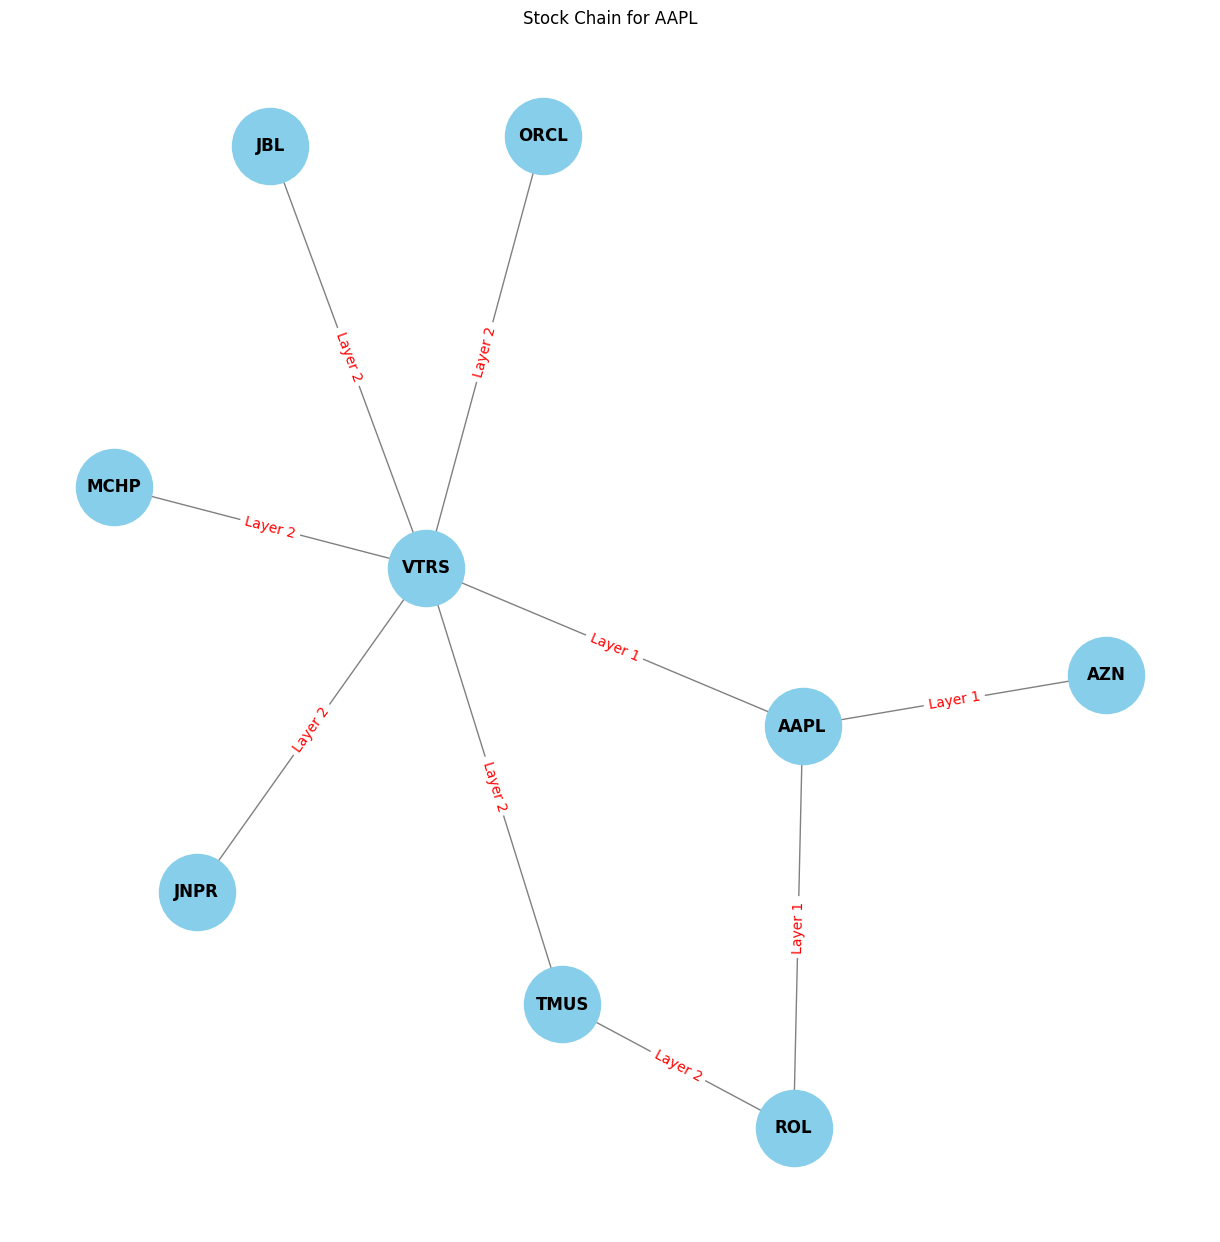

In [32]:
# Initialize a graph for the tree
G = nx.Graph()

# We need to input each pair from each layer.
pairs_layer_1 = [('AAPL', 'AZN'), ('AAPL', 'ROL'), ('AAPL', 'VTRS')]
pairs_layer_2 = [('ROL', 'TMUS'), ('VTRS', 'JNPR'), ('VTRS', 'JBL'), ('VTRS', 'ORCL'),
                ('VTRS', 'MCHP'), ('VTRS', 'TMUS')]

# Add each pair to the graph, by layer.
for pair in pairs_layer_1:
    G.add_edge(pair[0], pair[1], layer = 'Layer 1')

for pair in pairs_layer_2:
    G.add_edge(pair[0], pair[1], layer = 'Layer 2')

# Draw the graph
plt.figure(figsize = (12, 12))

# Set positions of the nodes to create a chain-like structure
pos = nx.spring_layout(G)

# Set nodes and the edges we defined
nx.draw(G, pos, with_labels = True, node_size = 3000, node_color = 'skyblue', font_size = 12,
        font_weight = 'bold', edge_color = 'grey')

# Adding edge labels for which layer each connection was created in
edge_labels = nx.get_edge_attributes(G, 'layer')
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_color='red')

# Show the plot
plt.title('Stock Chain for AAPL')
plt.show()








#### The library used above in networkx in conjunction with matplotlib made a really nice plot here, defining all the work we did in this notebook showing the cointegration starting with our core stock in AAPL.  You can see where we start in the middle and the results for each layer branching out.

## Notebook Summary for Cointegration Testing And Stock Chain Formation for - AAPL
#### In this notebook we took all of the work done thusfar and put it to the test.  We took our AAPL data pulled from our core stock data, used our optimized features, then ran cointegration testing to form stock chains centered around our starting root node.  These chains are abbreviated, as we kept a limit on pairs generated from each input pair as well as the p_threshold is all the way down to 0.01 which further limited pair generation otherwise the chain would be a lot bigger.  From here we can look to start organizing our trading strategy a little bit at a time, by looking at things like pair trading opportunities, hedging, and arbitrage strategies.  We can then look to backtest and forecast this chain as a unit.